User friendly features include:
* easy to fetch TFOP parameters
* handles any number of bands
* easy to switch between models
  - achromatic & chromatic
  - specifying covariates (default=Airmass)
  - linear model polynomial order (default=1)
* includes new parameterization by Espinosa+2018 for efficient sampling of impact parameter & Rp/Rs
* shows useful plots: quicklook, raw data, posteriors, FOV, etc

Note:
* To re-define the priors, manually edit `get_chi2_transit` method within `LPF` class

In [1]:
%load_ext autoreload

In [2]:
try:
    #installed locally
    from tfop_analysis import Star, Planet, LPF
except:
    #in muscat-ut3
    import sys
    sys.path.insert(0, '/ut3/muscat/github/tfop_code')
    from tfop_analysis import Star, Planet, LPF

## Get TFOP parameters for the host star

In [3]:
target = 'TOI-6449'
star = Star(target, source='tic')
star_params = star.params_to_dict()
star_params

TFOP notes: found in faint-star QLP search
Mstar=(0.45,0.02) Msun
Rstar=(0.45,0.02) Rsun
Rhostar=(4.81,0.55) rhosun
teff=(3356,157) K
logg=(4.78,0.01) cgs
feh=(0.00,0.10) dex


{'rstar': (0.454183, 0.0155273),
 'mstar': (0.454183, 0.0155273),
 'rhostar': (4.813903712185822, 0.5460704755765515),
 'teff': (3356.0, 157.0),
 'logg': (4.7778, 0.008642),
 'feh': (0.0, 0.1)}

## Get TFOP parameters for the planet candidate

In [4]:
planet = Planet(target, alias='b', star_params=star_params, source='toi')
planet_params = planet.params_to_dict()
planet_params

t0=(2459984.192328, 0.0018611) BJD
P=(2.4404127, 0.000413) d
Rp/Rs=[0.25979992 0.07893168]


{'t0': (2459984.192328, 0.0018611),
 'period': (2.4404127, 0.000413),
 'tdur': array([0.05641667, 0.00825   ]),
 'imp': (0.0, 0.1),
 'rprs': array([0.25979992, 0.07893168]),
 'a_Rs': (12.879247193048114, 0.48699053548942756)}

In [5]:
#timings from TTF
ing = 10338.018+2450000
mid = 10338.0465+2450000
egr = 10338.0746+2450000

In [6]:
# update timings 
planet_params['t0'] = (mid, 3/60/24)
planet_params['tdur'] = (81/60/24, 12/60/24)
planet_params['imp'] = (0.5,0.5)

In [7]:
#where's the photometry data?
!ls ./data/*.csv

./data/TOI6449b-jd20240128_MuSCAT4_g_measurements.csv
./data/TOI6449b-jd20240128_MuSCAT4_i_measurements.csv
./data/TOI6449b-jd20240128_MuSCAT4_r_measurements.csv
./data/TOI6449b-jd20240128_MuSCAT4_z_measurements.csv


## get photometry data into a dict={'band': 'dataframe'}


In [8]:
from pathlib import Path
import pandas as pd

def read_phot_data(phot_dir, date, bands=['g','r','i','z']):
    data = {}
    phot_files = list(Path(phot_dir).glob(f'*{date}*.csv'))
    errmsg = f"No photometry files found in {phot_dir}"
    assert len(phot_files)>0, errmsg
    
    for fp in phot_files:
        band = fp.name.split('_')[2]
        if band in bands:
            data[band] = pd.read_csv(fp)
    return data

In [9]:
#where to read data
phot_dir = './data'
date = '240128'
data = read_phot_data(phot_dir, date)
data.keys()

dict_keys(['i', 'z', 'r', 'g'])

In [10]:
#where to save pdf results
outdir = './results'
if not Path(outdir).exists():
    Path(outdir).mkdir()

## Quick look

In [11]:
from tfop_analysis import plot_ql, colors
from aesthetic.plot import savefig

inst = 'MuSCAT4'
exptimes = {'g':90, 'r':60, 'i': 30, 'z':29}
for i,b in enumerate(data):
    fig = plot_ql(data[b],
                  title=f'{target}.01 | LCO-2m-FTS/{inst} | {date} | {b}=band',
                  exptime=exptimes[b],
                  mcolor=colors[b],
                  binsize=10/60/24,
                  figsize=(10,10),
                  font_size=16,
                  title_height=0.93
                 )
    if True:
        outfile = f"{outdir}/{target}.01_{date}_{inst}_{b}_ql.pdf"
        savefig(fig, outfile, dpi=300, writepdf=False)

2024-07-30T10:20:54.112376: made ./results/TOI-6449.01_240128_MuSCAT4_i_ql.pdf
2024-07-30T10:20:54.538500: made ./results/TOI-6449.01_240128_MuSCAT4_z_ql.pdf
2024-07-30T10:20:54.953920: made ./results/TOI-6449.01_240128_MuSCAT4_r_ql.pdf
2024-07-30T10:20:55.575885: made ./results/TOI-6449.01_240128_MuSCAT4_g_ql.pdf


## Transit fit

In [12]:
#The number of bands supplied is automatically taken into account in modeling
lpf = LPF(name=target,                          #
          ticid=star.ticid,                     # for naming the files
          toi_name=star.toi_name,
          data=data,                            # dict with g,r,i,z as keys 
          inst='MuSCAT4',                       # for naming the files
          date=date,                            # obs date
          alias='.01',                          # for naming the files
          # bands=['r','i','z'],                # to select specific bands only
          model='chromatic',                    #
          star_params=star_params,              # dict
          planet_params=planet_params,          # dict
          time_offset=2460338,                  # 2450000 if None
          covariate='Airmass',                  
          lm_order=1,                           # polynomial order
          # mask_start=2460232.8,               # data between mask_start & mask_end are masked
          # mask_end=2460233.1
          use_r1r2=False,                        # impact param and Rp/Rs parameterization by Espinosa+2018
          DEBUG=False                           # prints details
         )
lpf

LPF(name='TOI-6449', date='240128', toi_name='TOI 6449.01', ticid='168936945', inst='MuSCAT4', alias='.01', bands=['g', 'r', 'i', 'z'], model='chromatic', time_offset=2460338, covariate='Airmass', lm_order=1, mask_start=None, mask_end=None, outdir='results', use_r1r2=False)

In [13]:
lpf.model_params

{'tc': (0.046500000171363354, 0.0020833333333333333),
 'a_Rs': (12.879247193048114, 0.48699053548942756),
 'imp': (0.5, 0.5),
 'k_g': array([0.25979992, 0.07893168]),
 'k_r': array([0.25979992, 0.07893168]),
 'k_i': array([0.25979992, 0.07893168]),
 'k_z': array([0.25979992, 0.07893168]),
 'd_g': (0, 0),
 'd_r': (0, 0),
 'd_i': (0, 0),
 'd_z': (0, 0)}

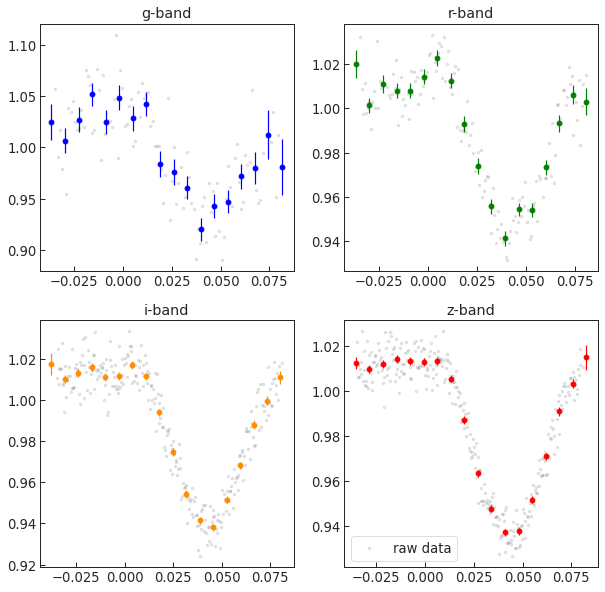

In [14]:
fig = lpf.plot_raw_data()

In [15]:
lpf.optimize_chi2_linear_baseline()

6048.90623319328 True [0.02440646 0.02069432 0.01792768 0.01656962]


array([0.02440646, 0.02069432, 0.01792768, 0.01656962])

In [16]:
p0 = lpf.model_params_vals
p0

[0.046500000171363354,
 12.879247193048114,
 0.5,
 0.2597999230176945,
 0.2597999230176945,
 0.2597999230176945,
 0.2597999230176945,
 0,
 0,
 0,
 0]

In [17]:
lpf.get_chi2_transit(p0)

1314.0237831384966

## Optimization

In [18]:
while True:
    lpf.optimize_chi2_transit(p0)
    if lpf.opt_result.success:
        break

Optimization successful!
---------------------
Optimized parameters:
tc: 0.04
a_Rs: 11.51
imp: 1.00
k_g: 0.49
k_r: 0.42
k_i: 0.42
k_z: 0.42
d_g: 0.01
d_r: -0.01
d_i: -0.00
d_z: -0.01


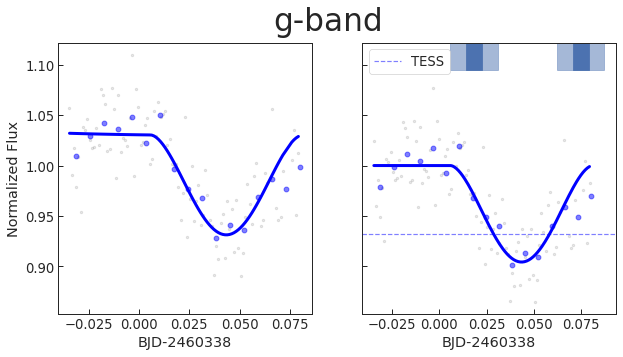

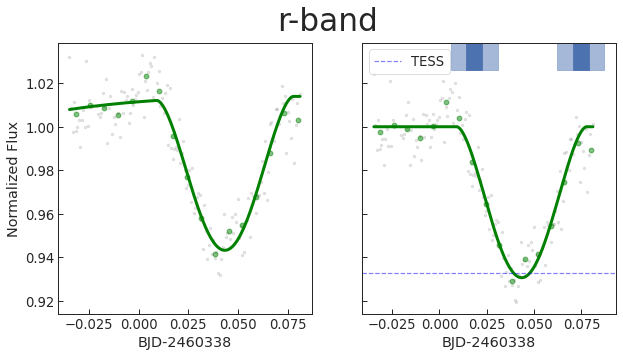

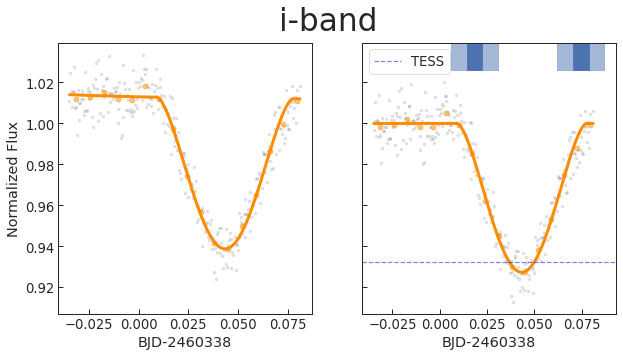

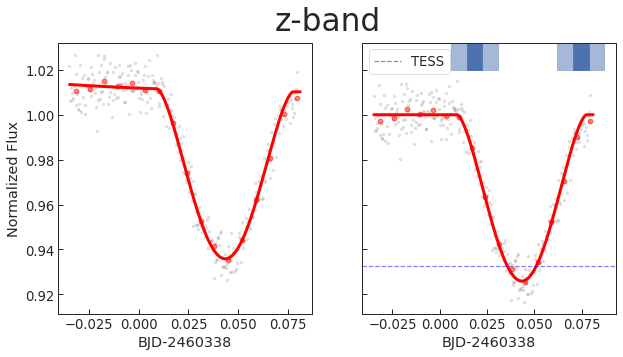

In [19]:
# using optimized parameters
pv = lpf.optimum_params
fig = lpf.plot_lightcurves(pv, figsize=(10,5))

## MCMC

In [20]:
lpf.sample_mcmc(nsteps=500)

100%|██████████| 500/500 [00:45<00:00, 11.10it/s]


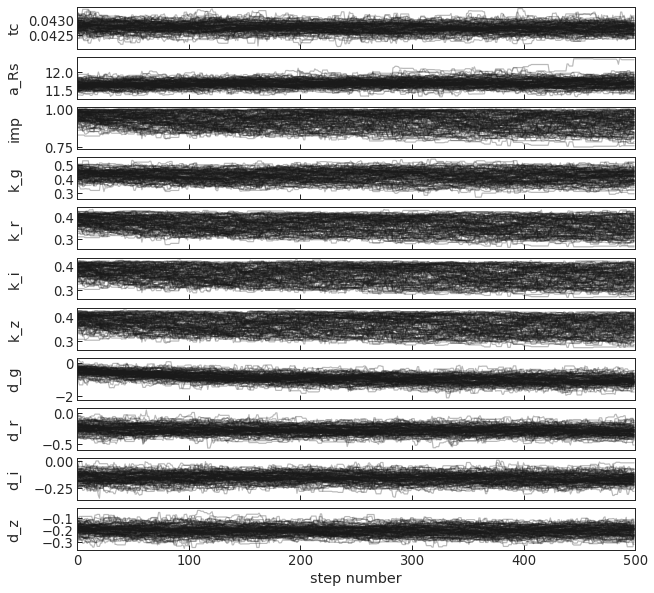

In [21]:
fig = lpf.plot_chain()

## Posteriors

In [22]:
df = lpf.get_mcmc_samples()
df.head()

,tc,a_Rs,imp,k_g,k_r,k_i,k_z,d_g,d_r,d_i,d_z
0,2.460338e+06,11.630816,0.967867,0.475297,0.390685,0.396214,0.399144,-0.321438,-0.214373,-0.109892,-0.207433
1,2.460338e+06,11.779027,0.919259,0.404517,0.361408,0.359868,0.364283,-0.347015,-0.399685,-0.153343,-0.180174
2,2.460338e+06,11.621299,0.922934,0.404555,0.365280,0.365276,0.368508,-0.745383,-0.126826,-0.208563,-0.125174
3,2.460338e+06,11.630734,0.984221,0.478877,0.408494,0.407348,0.405894,-0.358675,-0.338299,-0.179276,-0.159909
4,2.460338e+06,11.555840,0.932706,0.442845,0.377176,0.372433,0.374994,-0.490224,-0.225962,-0.184342,-0.165879


In [23]:
if False:
    outfile = f'{outdir}/{lpf.model}_samples.csv.gz'
    df.to_csv(outfile, index=False)
    print("Saved: ", outfile)

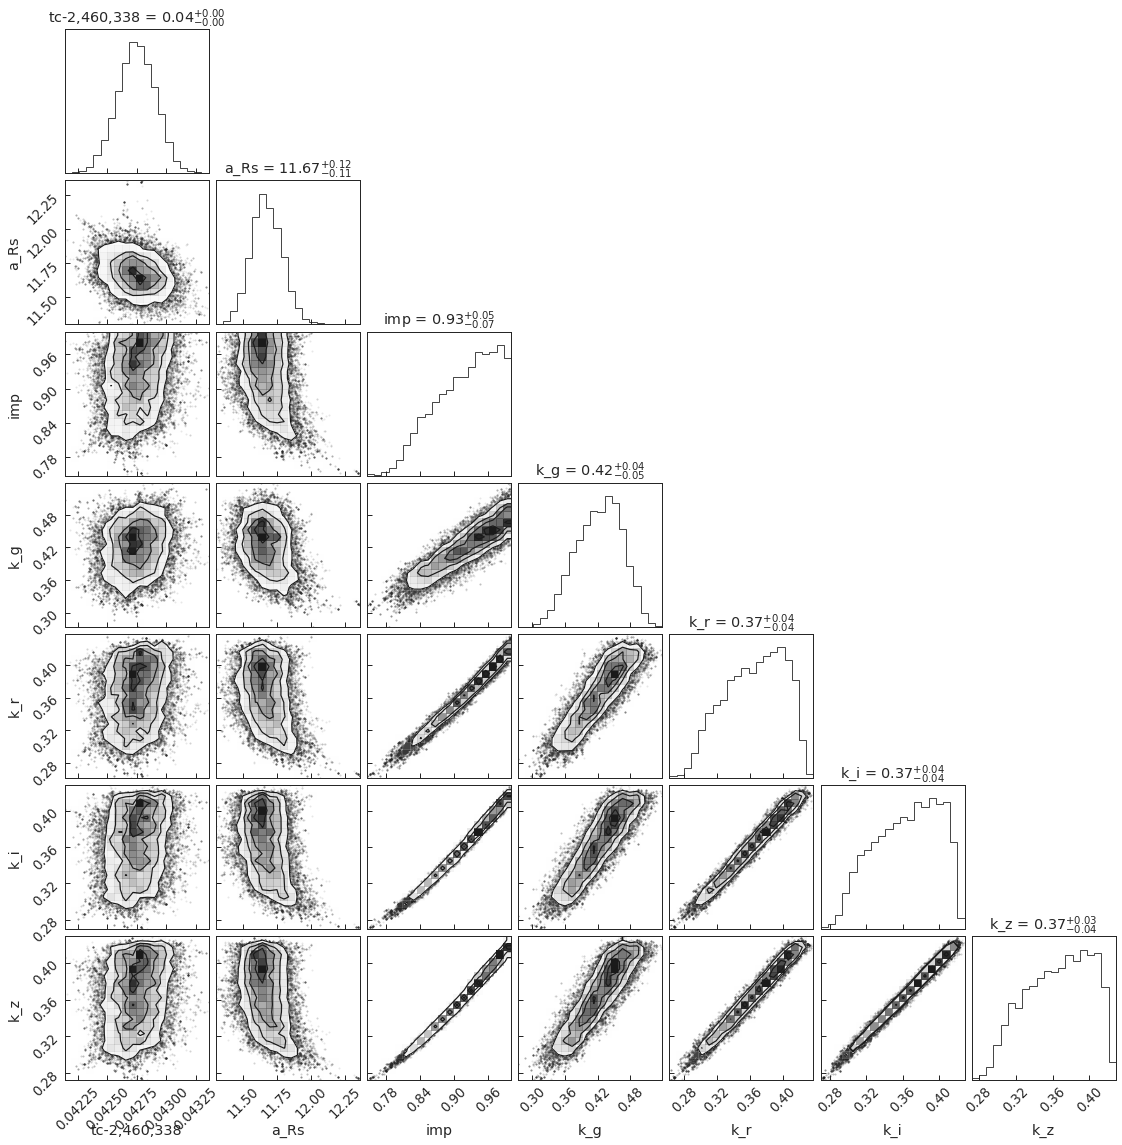

In [24]:
fig = lpf.plot_corner(start=0, end=7, transform=False)

Rp/Rs(g)^2 = 180.59 ppt
Rp/Rs(r)^2 = 135.75 ppt
Rp/Rs(i)^2 = 134.97 ppt
Rp/Rs(z)^2 = 136.15 ppt


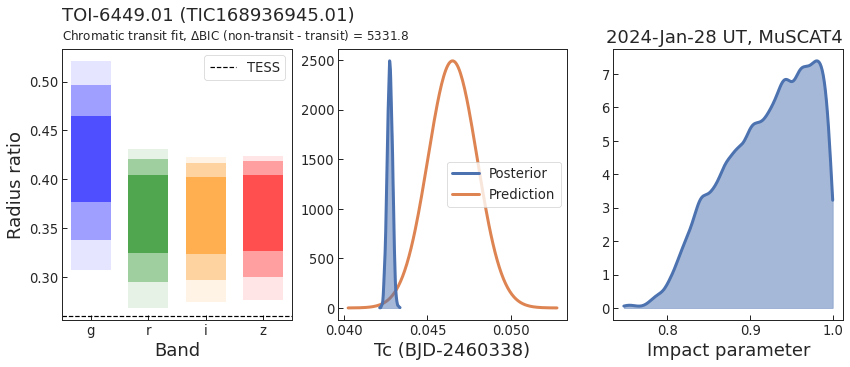

In [25]:
fig = lpf.plot_posteriors(nsigma=3, save=False, figsize=(14,5))

if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_posteriors.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Final fit

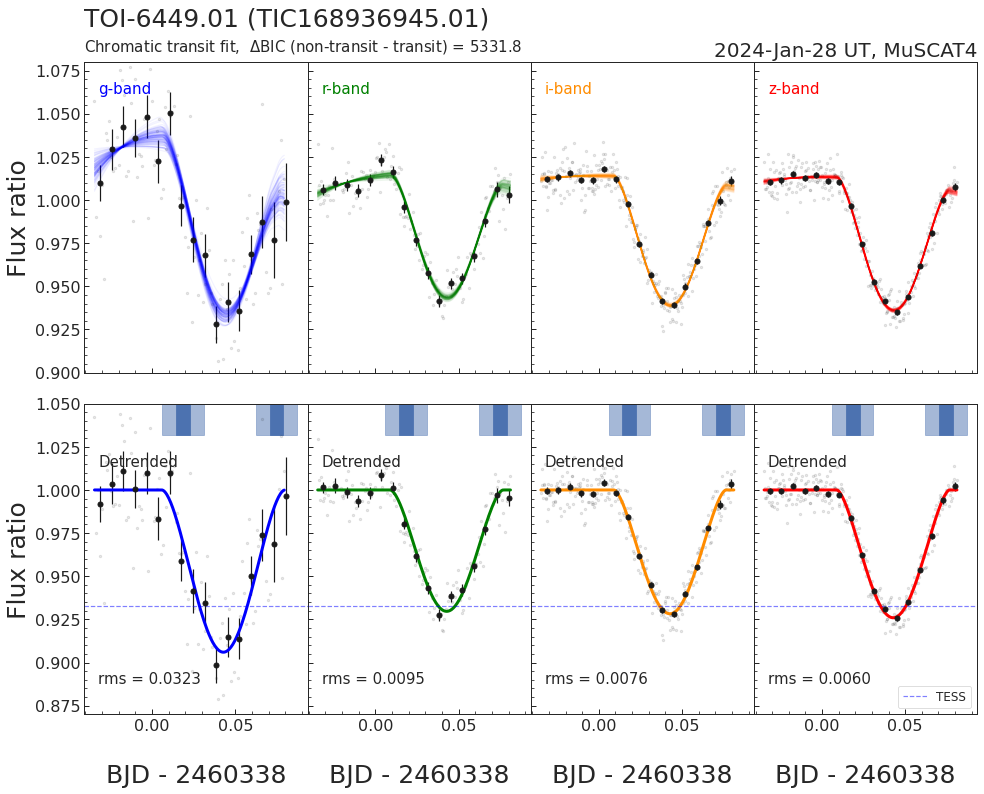

In [26]:
fig = lpf.plot_final_fit(ylims_top=(0.9,1.08),
                         ylims_bottom=(0.87,1.05), 
                         font_size=25,
                         save=False
                        )

if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_final_fit.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

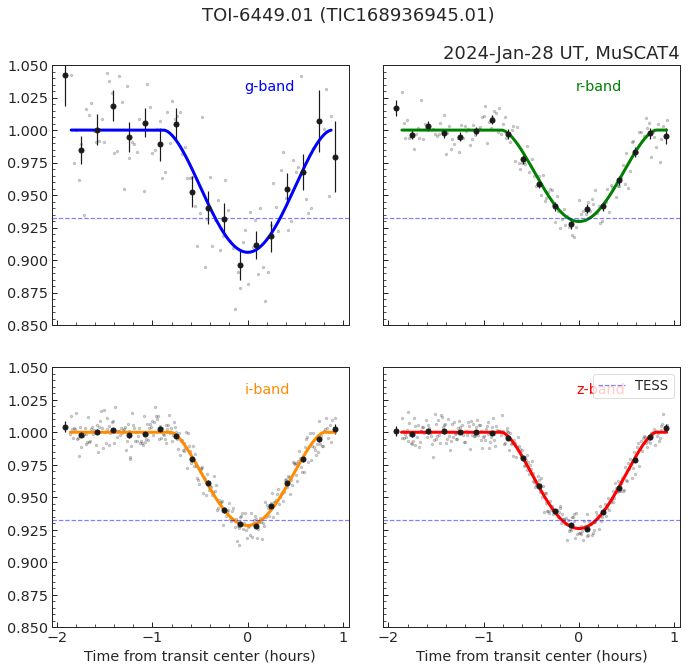

In [27]:
pv = lpf.best_fit_params
fig = lpf.plot_detrended_data_and_transit(pv, figsize=(10,10), 
                                          # xlims=(-1.3,1.3),
                                          ylims=(0.85, 1.05),
                                          title_height=0.95,
                                          font_size=18
                                         )

if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_models.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

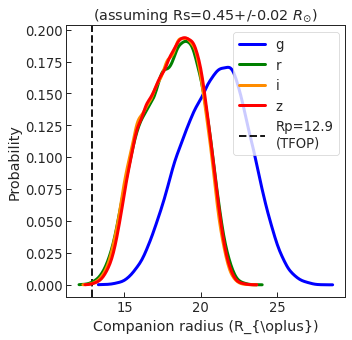

In [28]:
import astropy.units as u

fig = lpf.plot_radii(*star.rstar, unit=u.Rearth)

if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_radii.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

In [30]:
print(lpf.get_report())

Title: TIC 168936945.01 (TOI 6449.01) on UT 20240128 from FTS-2m-MuSCAT4 in g,r,i,z

We observed a full/ingress/egress on 20240128 UT in g,r,i,z and detected a 5.4-min early (1.8 sigma), [Rp/Rs]^2: 180.6,135.8,135.0,136.2 ppt event using XXX" uncontaminated/contaminated aperture.

Typical FWHM: NA
Predicted Tc: 10338.046500 ± 0.002083 BJD_TDB
Measured Tc: -2449999.957253 ± 0.000161 BJD_TDB
NEBcheck stars NOT cleared: NA


## FOV

In [31]:
ls data

ref-coj2m002-ep07-20240128-0077-e91.fits
ref-coj2m002-ep07-20240128-0077-e91.objects
TIC253864764-01_20240514_LCO-SAAO-1m0_zs_Observation-Notes.txt
TOI6449b-jd20240128_MuSCAT4_g_measurements.csv
TOI6449b-jd20240128_MuSCAT4_i_measurements.csv
TOI6449b-jd20240128_MuSCAT4_r_measurements.csv
TOI6449b-jd20240128_MuSCAT4_z_measurements.csv


In [34]:
ref_obj_file_path = './data/ref-coj2m002-ep07-20240128-0077-e91.objects'

In [35]:
!cat $ref_obj_file_path

# ./df/coj2m002-ep07-20240128-0077-e91.fits 2048 2048
# dark = 0
# median sky = 1211.88
# noise = 36.8223
# threshold  = 10
# hmin  = 368.223
# ADU range -1000 130000
# apradius = 20
# apADUmin = 10000
# apPixmin = 10
# Subframe 0 2048 0 2048
# Find on 20 2027 20 2027
       1     1970.278     1485.457     1971.000     1485.000 56823044.000   121771.109
       2     1708.647      259.782     1709.000      259.000 28096812.000   111071.742
       3     1110.477      578.564     1111.000      578.000 14153306.000    87234.750
       4     2028.555     1001.463     2027.000     1001.000  9805795.000    77633.086
       5      722.909     1920.957      723.000     1920.000  2871075.750    23422.521
       6     1286.084     1935.157     1287.000     1935.000  2047765.500    17144.639
       7      762.149       37.083      764.000       37.000  2033363.125    14371.267
       8      715.820     1876.878      717.000     1877.000  1907206.875    16182.602
       9      868.313     1454.725 

In [36]:
star.ra, star.dec

(125.930455146652, -5.18949555185015)

In [37]:
best_cIDs = [4,5,7,8,9,10]
best_aper_pix = 22

ref = 'ref-coj2m002-ep09-20240128-0075-e91'

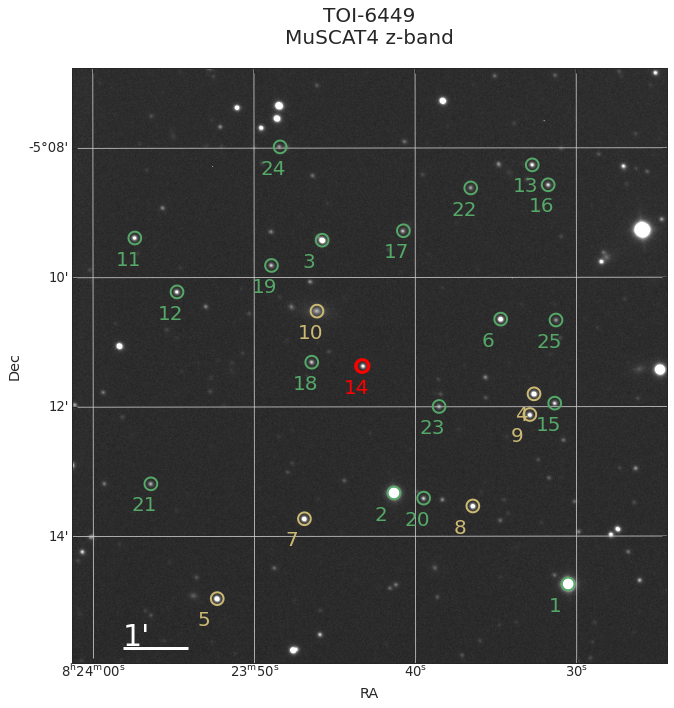

In [39]:
from aesthetic.plot import savefig

ra, dec = star.ra, star.dec
afphot_dir = f'/ut3/muscat/reduction_afphot/{lpf.inst.lower()}/{date}/{target}/reference'
ref_fits_file_path = f'{afphot_dir}/{ref}.fits'
ref_obj_file_path = f'{afphot_dir}/{ref}.objects'

fig = lpf.plot_fov(ra, dec, 
                   ref_fits_file_path, ref_obj_file_path,
                   phot_aper_pix=best_aper_pix,
                   cmap='gray',
                   contrast=0.1,
                   target_ID=14,
                   cIDs=best_cIDs,
                   cIDs_color='y',
                   marker_color='g',
                   text_offset=(0.005, -0.007),
                   scale_color='w',
                   font_size=20,
                   title_height=0.95
                  )
if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_z_FOV.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

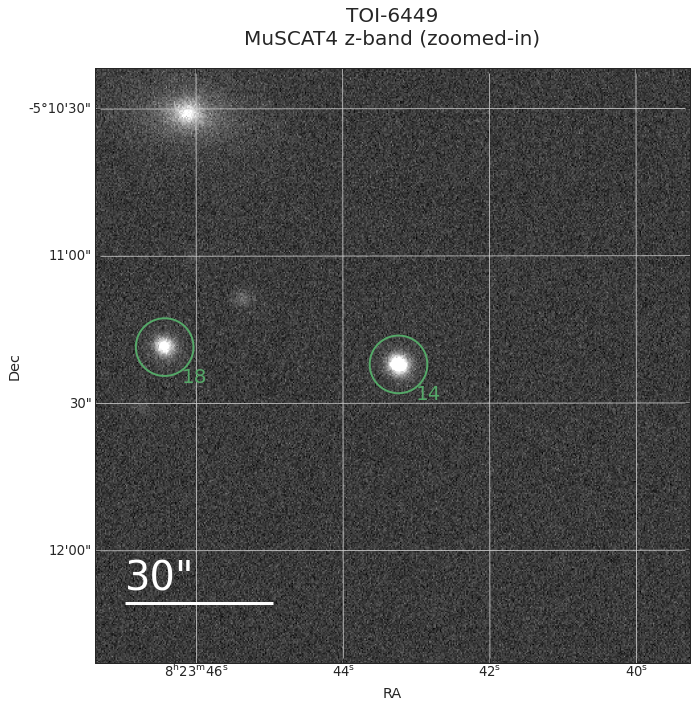

In [41]:
from aesthetic.plot import savefig

fig = lpf.plot_fov_zoom(ra, dec, 
                        ref_fits_file_path, 
                        ref_obj_file_path,
                        zoom_rad_arcsec=60,
                        bar_arcsec=30,
                        phot_aper_pix=best_aper_pix,
                        cmap='gray',
                        contrast=0.1,
                        marker_color='g',
                        text_offset=(-0.001, -0.002),
                        scale_color='w',
                        font_size=20,
                        title_height=0.95,
                  )
if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_z_FOV_zoom.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Compare to Gaia

In [42]:
gaia_sources = star.get_gaia_sources(rad_arcsec=60)
gaia_sources.tail()

Querying Gaia sources 60" around TOI-6449: (125.9305, -5.1895) deg.


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance,distance_arcsec
5,1635721458409799680,Gaia DR2 3065970448725166592,3065970448725166592,1229802523,2015.5,125.943584,0.046124,-5.188518,0.035130,0.890090,...,0.0616,200111,0.729568,0.612295,0.832648,0.561501,0.484217,0.638786,0.786665,47.199900
6,1635721458409799680,Gaia DR2 3065970306992482304,3065970306992482304,1420012143,2015.5,125.919668,6.826816,-5.198015,4.014375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.822693,49.361581
7,1635721458409799680,Gaia DR2 3065970341350172160,3065970341350172160,1655416117,2015.5,125.944783,0.202826,-5.191909,0.156519,0.134663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.868291,52.097472
8,1635721458409799680,Gaia DR2 3065970306990616704,3065970306990616704,362959562,2015.5,125.930888,10.120919,-5.205093,15.193645,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.936199,56.171948
9,1635721458409799680,Gaia DR2 3065970306990648832,3065970306990648832,1545302146,2015.5,125.917792,0.756717,-5.199268,0.582386,-0.766882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957266,57.435948


In [43]:
from astropy.io import fits
from glob import glob

fl = glob(f"/ut3/muscat/reduction_afphot/{lpf.inst.lower()}/{date}/{target}/reference/*.fits")
header = fits.getheader(fl[-1])
pixscale = header['pixscale']
pixscale

0.267

In [44]:
#distance to nearest stars in pix
gaia_sources["distance_arcsec"].head()/pixscale

0      0.000051
1    126.752936
2    147.341610
3    151.077080
4    175.694529
Name: distance_arcsec, dtype: float64

In [45]:
#aper radius in arcsec
best_aper_pix*pixscale

5.8740000000000006

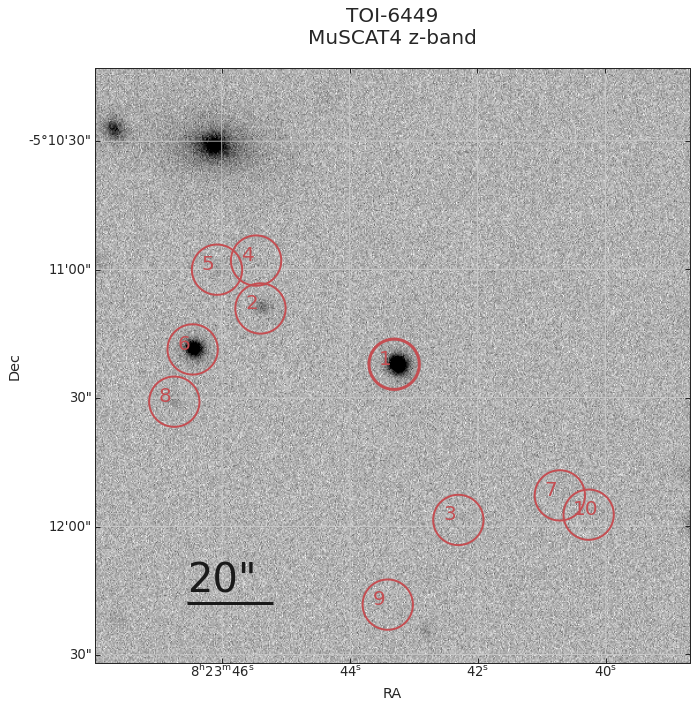

In [46]:
from aesthetic.plot import savefig

afphot_dir = f'/ut3/muscat/reduction_afphot/{lpf.inst.lower()}/{date}/{target}/reference'
fits_file_path = f'{afphot_dir}/{ref}.fits'

fig = lpf.plot_gaia_sources(fits_file_path, 
                            gaia_sources, 
                            phot_aper_pix=best_aper_pix,
                            text_offset=(0.001, 0),
                            fov_padding=1.2,
                            cmap='gray_r',
                            contrast=0.1,
                            bar_arcsec=20,
                            marker_color='r',
                            scale_color='k',
                            font_size=20,
                            title_height=0.95,
                           )
if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_r_FOV_gaia_sources.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Comparison of results

In [11]:
import pandas as pd
from corner import corner

df1 = pd.read_csv('muscat4/TOI-6449/tfop/chromatic_samples.csv.gz')
df2 = pd.read_csv('muscat4/TOI-6449/tfop_transform/chromatic_samples_transform.csv.gz')

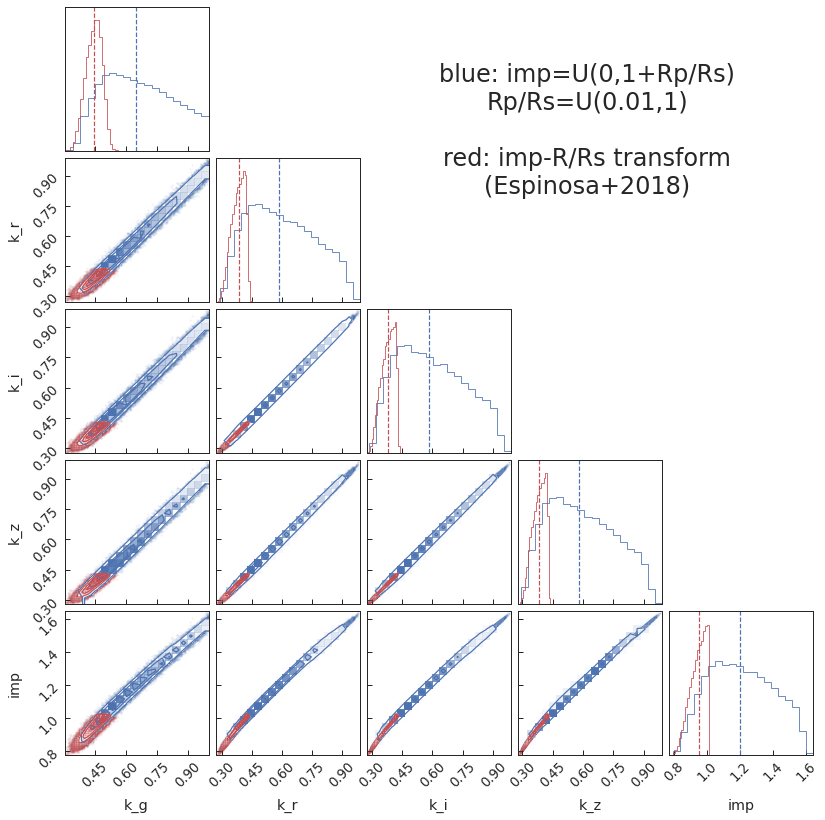

In [69]:
import numpy as np

cols = ['k_g','k_r','k_i','k_z','imp']
fig = corner(df1[cols], color='b', show_titles=False, quantiles=[0.5])
_ = corner(df2[cols], fig=fig, weights=np.ones(len(df2))*len(df1)/len(df2), quantiles=[0.5], color='r')
fig.suptitle(f"blue: imp=U(0,1+Rp/Rs)\nRp/Rs=U(0.01,1)\n\nred: imp-R/Rs transform\n(Espinosa+2018)", 
             y=0.9, x=0.7, fontsize=24);